# 都道府県ごとの集計データの扱い

都道府県ごとの合計データを処置変数と結果変数に使う場合

- 人口が交絡している
- 係数の解釈のため、１人あたりの値にして標準化したい

とい理由から、人口で割ったほうがいい


## 割ることが交絡のコントロールになる理由

#### 欠落変数バイアス

- long model: $y = \alpha p + \beta x + \varepsilon$
- short model: $y = \beta x + \varepsilon$

$p$は$x$にも影響を与えているとする

$p = \gamma_0 + \gamma_1 x + \epsilon$とおいてlong modelに代入すると

$$
y = \alpha (\gamma_0 + \gamma_1 x + \epsilon) + \beta x\\
= \alpha (\gamma_0 + \epsilon) + (\alpha \gamma_1 + \beta) x\\
$$

#### 割ることがコントロールになるのはなぜか

$$
y = \alpha p + \beta x + \varepsilon
$$

が

$$
\frac{y}{p} = \frac{\alpha p + \beta x + \varepsilon}{p}\\
= \alpha + \beta \frac{x}{p} + \frac{\varepsilon}{p}
$$


## シミュレーション

データ生成過程を次のように、$x, y$ともに人口$p$からの影響を受けると想定する。

$$
\begin{align}
x &= \alpha_x p\\
y &= \alpha_y p + \beta x
\end{align}
$$

$x\to y$の効果である$\beta$を推定したい


yとxをpで割った変換後の変数は次のようになる

$$
\frac{y}{p}= \frac{\alpha_y p + \beta x}{p} = \alpha_y + \beta \frac{x}{p}
$$

なので、$\beta$を推定するためには$\dfrac{y}{p}$を$\dfrac{x}{p}$に回帰させる必要がある

もしそのまま$y \sim x$にすると

$$
\begin{align}
y &= \alpha_y p + \beta x\\
&\to y = \alpha_y p + \beta \alpha_x p\\
&\to y = (\alpha_y + \beta \alpha_x) p\\
\end{align}
$$

もし$\dfrac{y}{p}$をそのままの$x$に回帰させると

$$
\begin{align}
\frac{y}{p} &= \alpha_y p + \beta (\alpha_x p)\\
  &= (\alpha_y + \beta \alpha_x) p\\
\end{align}
$$

となって$\alpha_y$のぶんがバイアスに

In [18]:
import numpy as np
import pandas as pd

np.random.seed(0)
n = 1000
populations = np.random.lognormal(mean=10, size=n).astype(int)
alpha_x = 10
alpha_y = 5
beta = 3
x = alpha_x * populations + np.random.normal(scale=1000, size=n)
y = alpha_y * populations + beta * x + np.random.normal(scale=1000, size=n)  # xとyは微弱な相関

In [19]:
df = pd.DataFrame(dict(y=y, x=x, population=populations)).sort_values("population").assign(
    # 人口あたりのy, xを計算する
    ypp = lambda self: self.y / self.population,
    xpp = lambda self: self.x / self.population,
)
df

,y,x,population,ypp,xpp
589,4.027881e+04,1.102808e+04,1047,38.470685,10.533029
685,4.572945e+04,1.284439e+04,1293,35.366936,9.933786
271,5.229187e+04,1.516537e+04,1376,38.002815,11.021341
427,5.349774e+04,1.519857e+04,1422,37.621479,10.688163
334,5.234335e+04,1.479737e+04,1541,33.967129,9.602449
...,...,...,...,...,...
465,8.600487e+06,2.457784e+06,245844,34.983513,9.997333
734,9.365887e+06,2.676012e+06,267587,35.001279,10.000530
898,1.032228e+07,2.949389e+06,294909,35.001583,10.001013
494,1.142114e+07,3.262962e+06,326512,34.979244,9.993391


yppとxppの相関が弱いことから、
xとyの相関はpopulationによる交絡の影響を受けていることがわかる

<AxesSubplot:xlabel='xpp', ylabel='ypp'>

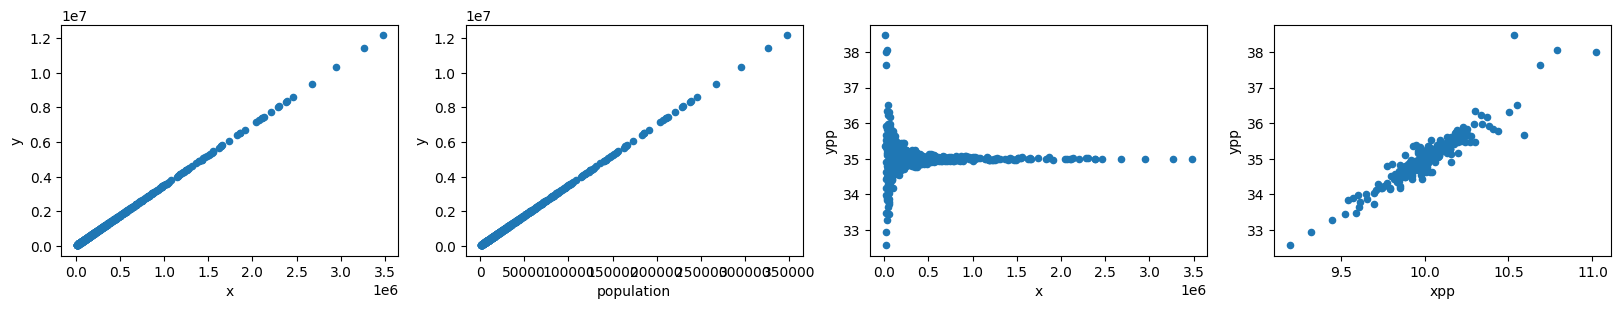

In [20]:
import matplotlib.pyplot as plt
fix, axes = plt.subplots(ncols=4, figsize=[20, 3])
df.plot.scatter(x="x", y="y", ax=axes[0])
df.plot.scatter(x="population", y="y", ax=axes[1])
df.plot.scatter(x="x", y="ypp", ax=axes[2])  # 線形性が満たされないのでそれによるバイアスが入りそう
df.plot.scatter(x="xpp", y="ypp", ax=axes[3])

しかし、可能なら`ypp ~ xpp`よりも`y ~ x + population`のほうが良い気がする

In [21]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

Stargazer([
    smf.ols("y ~ x", data=df).fit(),
    smf.ols("y ~ x + population", data=df).fit(),
    smf.ols("ypp ~ x", data=df).fit(),
    smf.ols("ypp ~ xpp", data=df).fit(),
])